In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
featureMapsNumber = 128
featureMapKernelSize = 3

maxPoolingStride = 2
maxPoolingKernelSize = 3

def convolution_block(input_layer, should_preactivate = False, dropout_rate = 0.2, dropout_mode = 'spatial'):
    convolution_block_input = Input(shape=(int(input_layer.shape[1]), int(input_layer.shape[2])))
    model = convolution_block_input
    
    if(should_preactivate):
        model = BatchNormalization()(model)
        model = ELU()(model)
        model = Conv1D(
            featureMapsNumber, 
            kernel_size=featureMapKernelSize, 
            padding='same', 
            activation='linear', 
            kernel_initializer = 'he_normal'
        )(model)
    else:
        model = Conv1D(
            featureMapsNumber, 
            kernel_size=featureMapKernelSize, 
            padding='same', 
            activation='linear', 
            kernel_initializer = 'he_normal'
        )(model)        
        model = BatchNormalization()(model)
        model = ELU()(model)
        
    convolution_block_output = model
    
    if(dropout_mode == 'vanilla'):
        convolution_block_output = Dropout(dropout_rate)(model)
    if(dropout_mode == 'spatial'):
        convolution_block_output = SpatialDropout1D(dropout_rate)(model)
        
    return Model(
        inputs=[convolution_block_input], 
        outputs=[convolution_block_output]
    )(input_layer)



In [0]:
def dpcnn_block(input_layer, dropout_rate = 0.2, dropout_mode = 'spatial'):
    dpcnn_block_input = Input(shape=(int(input_layer.shape[1]), int(input_layer.shape[2])))
    dpcnn_block_pool = MaxPooling1D(pool_size=3, strides=2, padding='valid')(dpcnn_block_input)
    
    dpcnn_conv_1 = convolution_block(
        dpcnn_block_pool, 
        should_preactivate = True, 
        dropout_mode = dropout_mode,
        dropout_rate = dropout_rate
    )
    dpcnn_conv_2 = convolution_block(
        dpcnn_conv_1, 
        should_preactivate = True, 
        dropout_mode = dropout_mode,
        dropout_rate = dropout_rate
    )
    
    dpcnn_block_output = add([dpcnn_conv_2, dpcnn_block_pool])
    
    return Model(
        inputs=[dpcnn_block_input], 
        outputs=[dpcnn_block_output]
    )(input_layer)

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    extractor_block_input = Input(shape=(int(inputLayer.shape[1]), int(inputLayer.shape[2])))

    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(block_1_features)
    
    return Model(
        inputs = [extractor_block_input], 
        outputs=[extractor_block_output]
    )(inputLayer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    trainable = False
)(input_layer)

custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

preprocess_1 = convolution_block(averaged_embedding_layer, dropout_mode = 'spatial')
preprocess_2 = convolution_block(preprocess_1, dropout_mode = 'spatial')

model = add([preprocess_1, preprocess_2])

model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)

model = concatenate([
    Flatten()(model), 
    yoon_kim_feature_extractor(featureMapsNumber, model)
])
output_layer = classification_block(model)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

Large Batch Training

In [13]:
history = train_with_cv(model, batchSize=128, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 85888/102124 [========================>.....] - ETA: 22s - loss: 0.1496 - acc: 0.9562

102124/102124 [==============================] - 152s 1ms/step - loss: 0.1415 - acc: 0.9585 - val_loss: 0.0822 - val_acc: 0.9756
Epoch 2/32
 50048/102124 [=============>................] - ETA: 1:07 - loss: 0.0865 - acc: 0.9742

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0852 - acc: 0.9744 - val_loss: 0.0689 - val_acc: 0.9787
roc-auc: 0.9404 - roc-auc_val: 0.9383                                                                                                    
Epoch 3/32
 22656/102124 [=====>........................] - ETA: 1:42 - loss: 0.0772 - acc: 0.9759

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0772 - acc: 0.9762 - val_loss: 0.0672 - val_acc: 0.9787
Epoch 4/32
 25984/102124 [======>.......................] - ETA: 1:38 - loss: 0.0720 - acc: 0.9777

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0723 - acc: 0.9773 - val_loss: 0.0647 - val_acc: 0.9795
roc-auc: 0.9564 - roc-auc_val: 0.9495                                                                                                    
Epoch 5/32
 16896/102124 [===>..........................] - ETA: 1:49 - loss: 0.0688 - acc: 0.9781

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0692 - acc: 0.9778 - val_loss: 0.0619 - val_acc: 0.9798
Epoch 6/32
 23808/102124 [=====>........................] - ETA: 1:40 - loss: 0.0679 - acc: 0.9782

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0666 - acc: 0.9784 - val_loss: 0.0598 - val_acc: 0.9800
roc-auc: 0.966 - roc-auc_val: 0.9564                                                                                                    
Epoch 7/32
 16512/102124 [===>..........................] - ETA: 1:50 - loss: 0.0634 - acc: 0.9791

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0636 - acc: 0.9790 - val_loss: 0.0586 - val_acc: 0.9804
Epoch 8/32
 23680/102124 [=====>........................] - ETA: 1:41 - loss: 0.0615 - acc: 0.9800

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0624 - acc: 0.9793 - val_loss: 0.0584 - val_acc: 0.9804
roc-auc: 0.9701 - roc-auc_val: 0.9594                                                                                                    
Epoch 9/32
 16384/102124 [===>..........................] - ETA: 1:50 - loss: 0.0619 - acc: 0.9795

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0604 - acc: 0.9798 - val_loss: 0.0573 - val_acc: 0.9807
Epoch 10/32
 23552/102124 [=====>........................] - ETA: 1:41 - loss: 0.0595 - acc: 0.9800

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0592 - acc: 0.9799 - val_loss: 0.0587 - val_acc: 0.9797
roc-auc: 0.9731 - roc-auc_val: 0.9591                                                                                                    
Epoch 11/32
 16384/102124 [===>..........................] - ETA: 1:49 - loss: 0.0594 - acc: 0.9795

102124/102124 [==============================] - 140s 1ms/step - loss: 0.0577 - acc: 0.9803 - val_loss: 0.0560 - val_acc: 0.9809
Epoch 12/32
 23552/102124 [=====>........................] - ETA: 1:41 - loss: 0.0561 - acc: 0.9807

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0568 - acc: 0.9804 - val_loss: 0.0563 - val_acc: 0.9810
roc-auc: 0.9755 - roc-auc_val: 0.9619                                                                                                    
Epoch 13/32
 16384/102124 [===>..........................] - ETA: 1:50 - loss: 0.0555 - acc: 0.9805

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0556 - acc: 0.9807 - val_loss: 0.0574 - val_acc: 0.9802

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00014358729822561145.
Epoch 14/32
 17152/102124 [====>.........................] - ETA: 1:49 - loss: 0.0548 - acc: 0.9806

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0547 - acc: 0.9810 - val_loss: 0.0551 - val_acc: 0.9811
roc-auc: 0.9779 - roc-auc_val: 0.9622                                                                                                    
Epoch 15/32
 14848/102124 [===>..........................] - ETA: 1:51 - loss: 0.0556 - acc: 0.9813

102124/102124 [==============================] - 140s 1ms/step - loss: 0.0538 - acc: 0.9813 - val_loss: 0.0544 - val_acc: 0.9815
Epoch 16/32
 22912/102124 [=====>........................] - ETA: 1:42 - loss: 0.0519 - acc: 0.9823

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0534 - acc: 0.9814 - val_loss: 0.0548 - val_acc: 0.9810
roc-auc: 0.9791 - roc-auc_val: 0.9631                                                                                                    
Epoch 17/32
 16128/102124 [===>..........................] - ETA: 1:50 - loss: 0.0535 - acc: 0.9814

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0530 - acc: 0.9814 - val_loss: 0.0560 - val_acc: 0.9805
Epoch 18/32
 23424/102124 [=====>........................] - ETA: 1:41 - loss: 0.0526 - acc: 0.9813

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0521 - acc: 0.9815 - val_loss: 0.0558 - val_acc: 0.9805
roc-auc: 0.9802 - roc-auc_val: 0.9635                                                                                                    
Epoch 19/32
 16256/102124 [===>..........................] - ETA: 1:50 - loss: 0.0509 - acc: 0.9818

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0515 - acc: 0.9818 - val_loss: 0.0546 - val_acc: 0.9810
Epoch 20/32
 23424/102124 [=====>........................] - ETA: 1:41 - loss: 0.0514 - acc: 0.9819

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0511 - acc: 0.9818 - val_loss: 0.0542 - val_acc: 0.9813
roc-auc: 0.981 - roc-auc_val: 0.9645                                                                                                    
Epoch 21/32
 16384/102124 [===>..........................] - ETA: 1:50 - loss: 0.0524 - acc: 0.9814

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0511 - acc: 0.9819 - val_loss: 0.0538 - val_acc: 0.9814
Epoch 22/32
 23552/102124 [=====>........................] - ETA: 1:41 - loss: 0.0489 - acc: 0.9823

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0500 - acc: 0.9821 - val_loss: 0.0562 - val_acc: 0.9802
roc-auc: 0.9816 - roc-auc_val: 0.9643                                                                                                    
Epoch 23/32
 16384/102124 [===>..........................] - ETA: 1:50 - loss: 0.0494 - acc: 0.9821

102124/102124 [==============================] - 142s 1ms/step - loss: 0.0501 - acc: 0.9820 - val_loss: 0.0550 - val_acc: 0.9807
Epoch 24/32
 23424/102124 [=====>........................] - ETA: 1:41 - loss: 0.0497 - acc: 0.9826

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0497 - acc: 0.9823 - val_loss: 0.0542 - val_acc: 0.9812

Epoch 00024: ReduceLROnPlateau reducing learning rate to 4.575267666950822e-05.
roc-auc: 0.9823 - roc-auc_val: 0.9648                                                                                                    
Epoch 25/32
 13312/102124 [==>...........................] - ETA: 1:54 - loss: 0.0506 - acc: 0.9816

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0496 - acc: 0.9822 - val_loss: 0.0538 - val_acc: 0.9814
Epoch 26/32
 22400/102124 [=====>........................] - ETA: 1:42 - loss: 0.0472 - acc: 0.9830

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0487 - acc: 0.9826 - val_loss: 0.0546 - val_acc: 0.9812
roc-auc: 0.9826 - roc-auc_val: 0.9644                                                                                                    
Epoch 27/32
 16000/102124 [===>..........................] - ETA: 1:50 - loss: 0.0465 - acc: 0.9835

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0488 - acc: 0.9825 - val_loss: 0.0542 - val_acc: 0.9812
Epoch 28/32
 23424/102124 [=====>........................] - ETA: 1:41 - loss: 0.0478 - acc: 0.9831

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0486 - acc: 0.9825 - val_loss: 0.0543 - val_acc: 0.9812
roc-auc: 0.983 - roc-auc_val: 0.9644                                                                                                    
Epoch 29/32
 16384/102124 [===>..........................] - ETA: 1:50 - loss: 0.0483 - acc: 0.9828

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0485 - acc: 0.9825 - val_loss: 0.0549 - val_acc: 0.9809
Epoch 30/32
 23552/102124 [=====>........................] - ETA: 1:41 - loss: 0.0489 - acc: 0.9822

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0487 - acc: 0.9825 - val_loss: 0.0546 - val_acc: 0.9810
roc-auc: 0.9834 - roc-auc_val: 0.9646                                                                                                    
Epoch 31/32
 16384/102124 [===>..........................] - ETA: 1:50 - loss: 0.0467 - acc: 0.9829

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0480 - acc: 0.9827 - val_loss: 0.0550 - val_acc: 0.9808
Epoch 32/32
 23552/102124 [=====>........................] - ETA: 1:41 - loss: 0.0467 - acc: 0.9835

102124/102124 [==============================] - 141s 1ms/step - loss: 0.0481 - acc: 0.9826 - val_loss: 0.0555 - val_acc: 0.9808
roc-auc: 0.9835 - roc-auc_val: 0.9644                                                                                                    


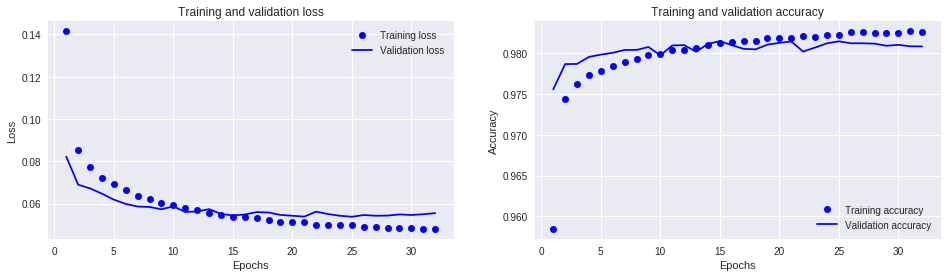

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 20s 613us/step
([0.05512124884797173, 0.9804271639672713], 0.9707713009584479)
